In [85]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from skimage import exposure
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift

In [36]:
movie = tifffile.imread('data/caiman_data.tif')
movie.shape

(3000, 170, 170)

### **Recognizing Motion and Preparing Your Imaging Data**

Before beginning motion correction, it is important to first recognize the type and extent of motion present in the calcium imaging dataset. This section introduces the process of visually and quantitatively identifying motion artifacts and determining whether rigid correction is appropriate. You will also prepare the dataset by generating a reference frame and ensuring consistent intensity across frames. These preparatory steps are essential for enabling accurate and reliable correction in the following stages.

**Learning goals:**

- Identify motion artifacts in calcium imaging data  
- Understand when rigid correction is appropriate  
- Choose and generate a suitable reference frame  
- Prepare the dataset for alignment (e.g., normalization, clipping)

**Visualize frame jitter**

**Example** Visualize motion 

In [11]:
segment = movie.copy()

def view_frame(frame_idx):
    plt.imshow(segment[frame_idx], cmap='gray')
    plt.title(f"Frame {frame_idx}")
    plt.show()

interact(view_frame, frame_idx=IntSlider(min=0, max=len(segment)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='frame_idx', max=2999), Output()), _dom_classes=('widget-…

**Exercise** Plot oth and 5th frame side by side

Text(0.5, 1.0, '5')

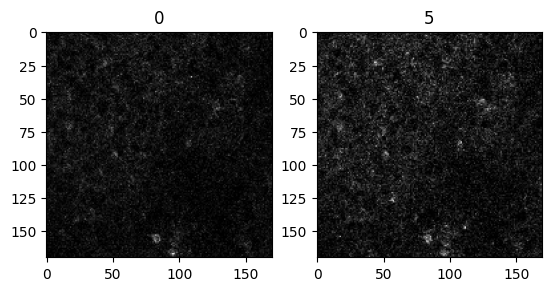

In [17]:
ind1 = 0
ind2 = 5

plt.subplot(121)
plt.imshow(movie[ind1], cmap='gray')
plt.title(ind1)

plt.subplot(122)
plt.imshow(movie[ind2], cmap='gray')
plt.title(ind2)

**Exercise** Plot mean projection from 0 to 100th frame and 1200 to 3000 frame side by side

Text(0.5, 1.0, '(1200:3000)')

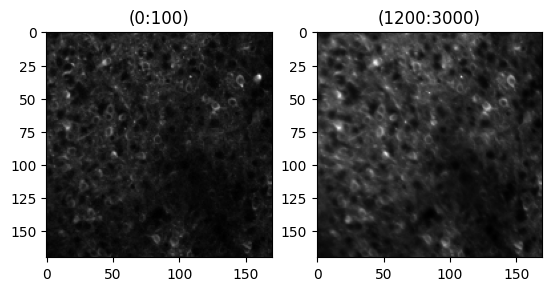

In [56]:
i1, e1 = 0, 100
i2, e2 = 1200, 3000

plt.subplot(121)
plt.imshow(movie[i1:e1 :, :].mean(axis=0), cmap='gray')
plt.title(f'({i1}:{e1})')

plt.subplot(122)
plt.imshow(movie[i2:e2 :, :].mean(axis=0), cmap='gray')
plt.title(f'({i2}:{e2})')

**Exercise** Make mean projection of all frames

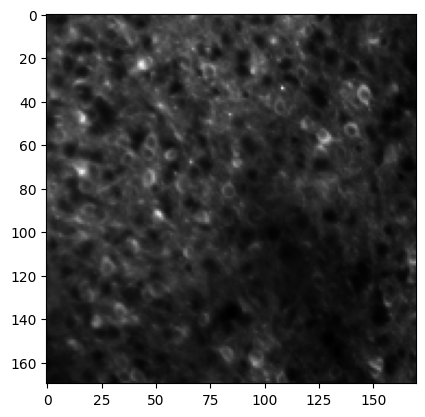

In [59]:
ref = movie.mean(axis = 0)
plt.imshow(ref, cmap='gray');

**Exercise** We need a stable reference. So let us choose stable frames to get reference image

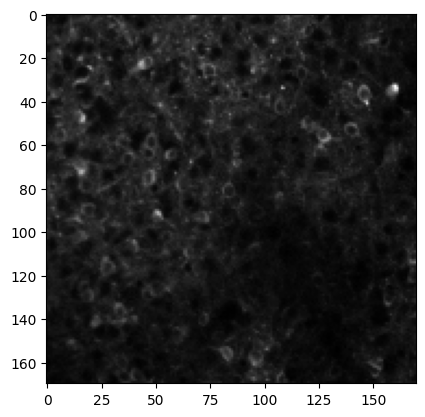

In [61]:
ref = movie[0:100].mean(axis = 0)
plt.imshow(ref, cmap='gray');

Aligning frames relies on comparing image intensities between each frame and a reference frame.

**Exercise** Normalize and clip the frames 

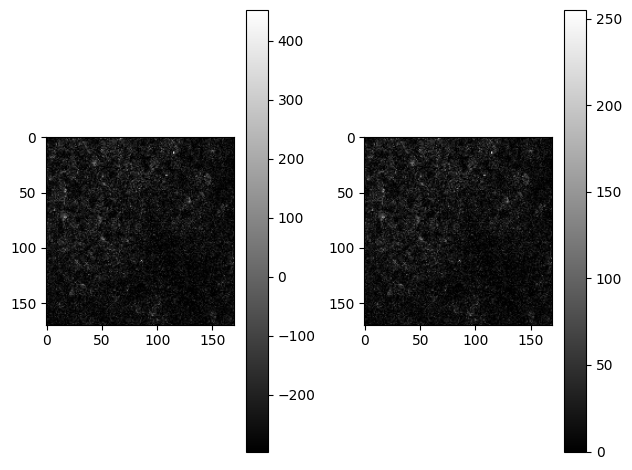

In [68]:
idx = 1000
frame = movie[idx]
nrm_frame = exposure.rescale_intensity(frame, out_range=(0, 255))

plt.subplot(121)
plt.imshow(frame, cmap='gray')
plt.colorbar()

plt.subplot(122)
plt.imshow(nrm_frame, cmap='gray')
plt.colorbar()

plt.tight_layout()

**Demo** Apply normalization and clipping to all frames

In [70]:
norm_movie = np.array([exposure.rescale_intensity(f, out_range=(0, 255)).astype(np.uint8) for f in movie])

### **Estimating Frame Shifts Relative to a Reference**

To correct for motion, it is necessary to know how much each frame in the movie has shifted relative to a stable reference. This section introduces the concept of shift estimation by comparing each frame to the reference image. The outcome is a set of displacement values for each frame that can be used to realign the dataset. By the end of this section, you will understand how motion is quantified and how to structure this information for use in the correction step.

**Learning goals:**

- Understand how to detect motion between two images  
- Learn how reference-based alignment works  
- Estimate and collect displacement values for each frame  
- Identify and verify outliers in motion estimates

Each shift is a pair of values: [dy, dx], indicating how much the image needs to move to align with the reference frame.

|                       | `dy` (Vertical Shift)     | `dx` (Horizontal Shift)   |
|-----------------------|---------------------------|---------------------------|
| **Meaning**           | Vertical movement         | Horizontal movement       |
| **Positive Value**    | Move frame **downward**   | Move frame **right**      |
| **Negative Value**    | Move frame **upward**     | Move frame **left**       |


**Exercise** Compute Shift Between reference and 0th frame

In [82]:
find = 0
frame = movie[find]

shift_val, _, _ = phase_cross_correlation(ref, frame)
shift_val

array([0., 0.], dtype=float32)

In [98]:
find =  2800# 2500, 2600, 2700, 2800
frame = movie[find]

shift_val, _, _ = phase_cross_correlation(ref, frame)
shift_val

array([-2., -2.], dtype=float32)

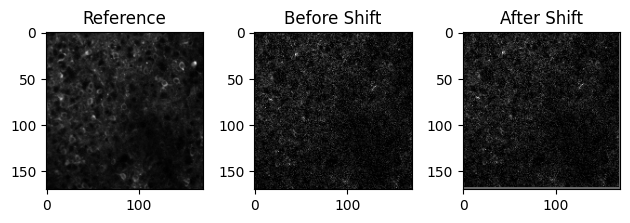

In [99]:
aligned = shift(frame, shift=shift_val)

plt.subplot(1, 3, 1)
plt.imshow(ref, cmap='gray')
plt.title("Reference")

plt.subplot(1, 3, 2)
plt.imshow(frame, cmap='gray')
plt.title("Before Shift")

plt.subplot(1, 3, 3)
plt.imshow(aligned, cmap='gray')
plt.title("After Shift")
plt.tight_layout()

**Exercise** Estimate shifts for all frames

In [100]:
shifts = np.array([
    phase_cross_correlation(ref, frame)[0]
    for frame in movie
])

The motion trace is a plot of frame-by-frame shifts along the X and Y directions. 

**A good trace should look have**
- small fluctuations.
- no sudden jumps between neighboring frames.

**Signs of outliers**
- sudden spike in shift (Y or X direction).
- flatline followed by a jump could suggest a movement event or an error in frame reading.
- one frame with extreme values compared to neighbors which may need to be excluded or handled separately.

**Exercise** Plot motion traces and spot outliers

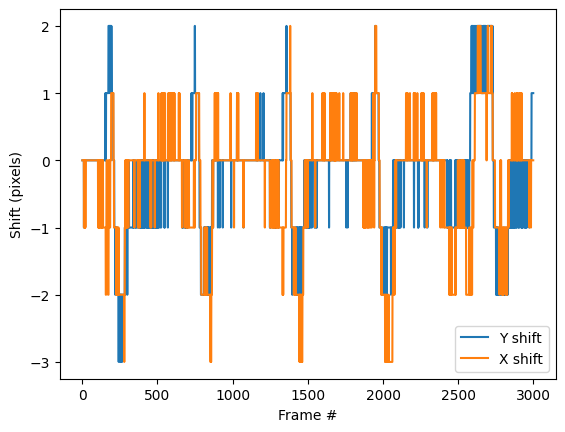

In [101]:
plt.plot(shifts[:, 0], label='Y shift')
plt.plot(shifts[:, 1], label='X shift')
plt.xlabel("Frame #")
plt.ylabel("Shift (pixels)")
plt.legend()

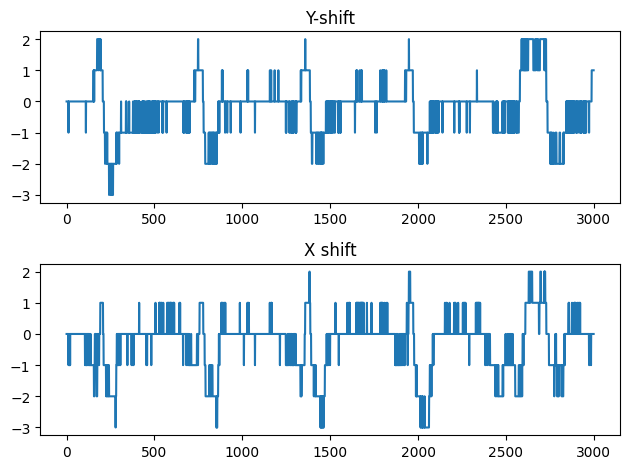

In [104]:
plt.subplot(211)
plt.plot(shifts[:, 0])
plt.title('Y-shift')

plt.subplot(212)
plt.plot(shifts[:, 1])
plt.title('X shift')

plt.tight_layout()

### **Applying Rigid Shifts to Correct Frame Alignment**

After estimating the shifts, the next step is to apply them in order to correct the motion. In this section, you will learn how to realign each frame using its calculated shift while managing interpolation and boundary effects. This process generates a new motion-corrected dataset that preserves spatial consistency over time. The focus will be on applying shifts efficiently and ensuring that no information is lost or distorted during the correction.

**Learning goals:**

- Apply stored motion values to shift individual frames  
- Choose and manage interpolation methods  
- Handle boundary effects and edge cases during shifting  
- Generate and store the corrected movie stack

### **Evaluating Correction Quality and Preparing for Analysis**

Once the data has been corrected, it is important to assess whether the correction has improved the alignment and stability of the movie. This section introduces methods for evaluating the effectiveness of motion correction using visual inspection, summary images, and motion plots. This evaluation ensures that the data is ready for downstream analyses such as segmentation and signal extraction.

**Learning goals:**

- Compare raw and corrected images visually  
- Generate summary projections to assess alignment  
- Plot motion traces to verify consistency  
- Confirm that correction improves signal stability